# Chapter 2: Modelling and Evaluation - Analyse

In [2]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [3]:
etf_daily = pd.read_csv('data/iShares Core MSCI World UCITS ETF USD  EUNL.DE.csv')
etf_monthly = pd.read_csv('data/iShares Core MSCI World UCITS ETF USD (Acc)_Monthly.csv')
fed_funds = pd.read_csv('data/Leitzins_USA_FED_Banken.csv')

## Statistical Significance Test and P-Values

## t-Tests

### Idee und Hypothosen

Aus den Korrelationsdaten und das Streudiagramm konnte man einen Zusammenhang zwischen dem Leitzins der EZB und den Adj Close Value des ETFs erkennen.

Daraus wurden folgende Hypothesen erstellt:

* Nullhypothese (H0): Es besteht keine statistisch signifikante Beziehung zwischen den Closed Adj.Value des MSCI World und dem Leitzins der EU-Zentralbank. Der Leitzins der EU-Zentralbank hat keinen signifikanten Enfluss auf den Closed Adj.Value des Aktienmarktes
* Alternativhypothese (H1): Es besteht eine statistisch signifikante Beziehung zwischen Closed Adj.Value des MSCI World und dem Leitzins der EU-Zentralbank. Der Leitzins der EU-Zentralbankhat hat einen signifikanten Enfluss auf den Closed Adj.Value des Aktienmarktes

t-Statistic: 159.82185338543297
p-value: 0.0


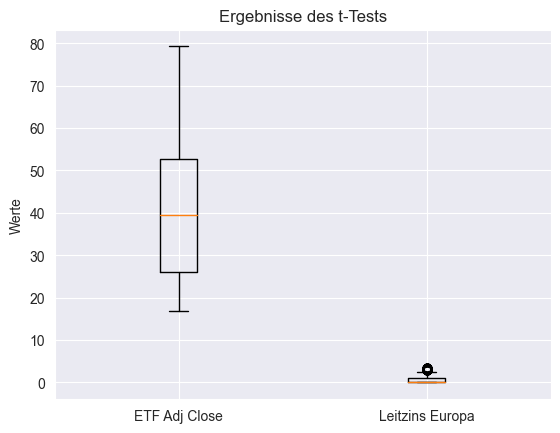


Durchschnittliche Werte:
Durchschnittliche t-Statistik: 160.43015661144207
Durchschnittlicher p-Wert: 0.0


In [11]:
etf_daily = pd.read_csv('data/iShares Core MSCI World UCITS ETF USD (Acc)_Monthly.csv')
EZB_Funds = pd.read_csv('data/leitzins Europa.csv')

eu_funds_sorted = EZB_Funds.sort_values(by='Date')
eu_funds_sorted.to_csv('data/generatedDatasets/leitzins Europa_sorted.csv', index=False)

# Werte für den t-Test extrahieren
etf_filtered = etf_daily.loc[(etf_daily['Date'] >= '2009-09-25') & (etf_daily['Date'] <= '2023-06-01'), ['Date', 'Adj Close']]
eu_funds_filtered = eu_funds_sorted.loc[(eu_funds_sorted['Date'] >= '2009-09-25') & (eu_funds_sorted['Date'] <= '2023-06-01'), ['Date', 'Percent per annum']]

etf_filtered.dropna(inplace=True)
eu_funds_filtered.dropna(inplace=True)

# print(etf_filtered)
# print(eu_funds_filtered)

# t-Test durchführen
t_statistic, p_value = stats.ttest_ind(etf_filtered['Adj Close'], eu_funds_filtered['Percent per annum'])

# Ausgabe der Ergebnisse
print("t-Statistic:", t_statistic)
print("p-value:", p_value)


data = [etf_filtered['Adj Close'], eu_funds_filtered['Percent per annum']]

# Boxplot erstellen
plt.boxplot(data, labels=['ETF Adj Close', 'Leitzins Europa'])
plt.ylabel('Werte')
plt.title('Ergebnisse des t-Tests')
plt.show()

# -------------------------------------------------------------------------------------------------------
# Bootstrap-Sampling
num_bootstrap_samples = 1000
bootstrap_samples = []

for _ in range(num_bootstrap_samples):
    sample_etf = np.random.choice(etf_filtered['Adj Close'], size=len(etf_filtered), replace=True)
    sample_eu_funds = np.random.choice(eu_funds_filtered['Percent per annum'], size=len(eu_funds_filtered), replace=True)
    bootstrap_samples.append((sample_etf, sample_eu_funds))

# print(bootstrap_samples)

# t-Test für Bootstrap-Samples durchführen
t_test_results = []

for sample_etf, sample_eu_funds in bootstrap_samples:
    t_statistic, p_value = stats.ttest_ind(sample_etf, sample_eu_funds)
    t_test_results.append((t_statistic, p_value))

# Durchschnittliche t-Statistik und p-Wert berechnen
average_t_value = np.mean([result[0] for result in t_test_results])
average_p_value = np.mean([result[1] for result in t_test_results])

# Ausgabe der Ergebnisse
print()
print("Durchschnittliche Werte:")
print("Durchschnittliche t-Statistik:", average_t_value)
print("Durchschnittlicher p-Wert:", average_p_value)


### Ergebnis
Die t-Statistik beträgt 160.4640825452364 und die durchschnittliche t-Statistik beträgt 160.68733124355262. Dies deutet darauf hin, dass es eine starke statistische Abweichung zwischen den Adj. Close-Werten und den Leitzins-Werten gibt.

Der (durchschnittliche) p-Wert liegt 0.0. Dies deutet darauf hin, dass die Unterschiede zwischen den Adj. Close-Werten und den Leitzins-Werten höchstwahrscheinlich nicht zufällig und statistisch signifikant sind.

Da der p-Wert bei 0 ist, haben wir ausreichende Beweise, um die Nullhypothese abzulehnen. Das bedeutet, dass die H0 Hypothese ablehnen können. Hingegen unterstützt das Ergebnis die Alternativhypothese und deutet darauf hin, dass der Leitzins der EU-Zentralbank einen signifikanten Einfluss auf den Closed Adj.Value des MSCI World hat.

## ANOVA

### Idee und Hypothesen

Aus den Korrelationsdaten und das Streudiagramm konnte man einen Zusammenhang zwischen dem Leitzins der FED für Banken und den Adj Close Value des ETFs erkennen.

Daraus wurden folgende Hypothesen erstellt:

* Nullhypothese (H0): Es besteht keine statistisch signifikante Beziehung zwischen den Closed Adj.Value des MSCI World und dem Leitzins der FED. Der Leitzins der FED hat keinen signifikanten Einfluss auf den Closed Adj.Value des Aktienmarktes
* Alternativhypothese (H1): Es besteht eine statistisch signifikante Beziehung zwischen Closed Adj.Value des MSCI World und dem Leitzins der FED. Der Leitzins der FED hat einen signifikanten Einfluss auf den Closed Adj.Value des Aktienmarktes

In [12]:
# Daten einlesen
etf_monthly = pd.read_csv('data/iShares Core MSCI World UCITS ETF USD (Acc)_Monthly.csv')
fed_funds = pd.read_csv('data/Leitzins_USA_FED_Banken.csv')

# Werte für den t-Test extrahieren
etf_filtered = etf_monthly.loc[(etf_monthly['Date'] >= '2009-10-01') & (etf_monthly['Date'] <= '2023-04-01'), ['Date', 'Adj Close']]
fed_funds_filtered = fed_funds.loc[(fed_funds['DATE'] >= '2009-10-01') & (fed_funds['DATE'] <= '2023-04-01'), ['DATE', 'FEDFUNDS']]

# Daten zusammenführen
etf_fedfunds_filtered_combined = pd.merge(etf_filtered, fed_funds_filtered, left_on='Date', right_on='DATE',  how='inner')
etf_fedfunds_filtered_combined.drop('DATE', axis=1, inplace=True)
etf_fedfunds_filtered_combined.drop('Date', axis=1, inplace=True)


etf_fedfunds_filtered_combined.to_csv('data/generatedDatasets/fed_funds_filtered.csv', index=False)

#Anova Test

anova_result = stats.f_oneway(etf_fedfunds_filtered_combined['Adj Close'], etf_fedfunds_filtered_combined['FEDFUNDS'])
print('f_statistic:', anova_result.statistic)
print('p-value:', anova_result.pvalue)

# ------------------------------
# Bootstrap-Sampling
num_bootstrap_samples = 1000
bootstrap_samples = []

for _ in range(num_bootstrap_samples):
    sample = etf_fedfunds_filtered_combined.sample(frac=1, replace=True)
    bootstrap_samples.append(sample)

# Ergebnisse des Anova-Tests für jedes Bootstrap-Sample speichern
anova_results = []
for sample in bootstrap_samples:
    anova_result = stats.f_oneway(sample['Adj Close'], sample['FEDFUNDS'])
    anova_results.append(anova_result)

# Ergebnisse anzeigen
#for i, sample in enumerate(bootstrap_samples):
#    print(f"Bootstrap Sample {i+1}:")
#    print(sample)
#    print("\n")
#
#    # Boxplot für das Bootstrap-Sample erstellen
#    plt.figure(figsize=(6, 4))
#    plt.boxplot(sample['Adj Close'])
#    plt.title(f"Bootstrap Sample {i+1}")
#    plt.ylabel("Value")
#    plt.show()

# Durchschnitt der F-Statistik und des p-Wertes berechnen
f_statistic_avg = np.mean([result.statistic for result in anova_results])
p_value_avg = np.mean([result.pvalue for result in anova_results])

# Ergebnisse anzeigen
print()
print("Durchschnittliche Werte:")
print("Durchschnittliche F-Statistic:", f_statistic_avg)
print("Durchschnittlicher p-value:", p_value_avg)


f_statistic: 858.7902100887729
p-value: 4.098098743618331e-93

Durchschnittliche Werte:
Durchschnittliche F-Statistic: 868.4648661858745
Durchschnittlicher p-value: 1.6905079694407086e-82


### Ergebnis
Die durchschnittliche F-Statistic beträgt 870.0604708441825. Dies deutet darauf hin, dass es eine starke statistische Abweichung zwischen den Adj. Close-Werten und den FED Leitzins-Werten gibt.

Der durchschnittliche p-Wert beträgt 3.3925782813532164e-85, dieser Wert liegt sehr nahe beim Wert Null. Dies deutet darauf hin, dass die Unterschiede zwischen den Adj. Close-Werten und den Leitzins-Werten höchstwahrscheinlich nicht zufällig und statistisch signifikant sind.

Aus den Ergebnissen des ANOVA-Tests kann nun interpretiert werden, dass Angesichts des kleinen p-Werts kann man die Nullhypothese (H0) ablehnen und akzeptieren die Alternativhypothese (H1). Dies bedeutet, dass es eine statistisch signifikante Beziehung zwischen dem Closed Adj.Value des MSCI World und dem Leitzins der FED gibt, und der Leitzins der FED einen signifikanten Einfluss auf den Closed Adj.Value des Aktienmarktes hat.

Die Durchschnittswerte der F-Statistik und des p-Werts über die Bootstrap-Samples unterstützen ebenfalls die Schlussfolgerung, dass H1 zutrifft. Der Durchschnitt der F-Statistik liegt bei 868.4648661858745 und der Durchschnitt des p-Werts bei 1.6905079694407086e-82.

## Chi-Square Test

### Erklärung und Idee
Definition der Hypothesen:
   * Nullhypothese (H0): Es besteht kein Zusammenhang zwischen der Rendite des ETFs und den Währungsumtauschdaten.
   * Alternativhypothese (HA): Es besteht ein Zusammenhang zwischen der Rendite des ETFs und den Währungsumtauschdaten.

Um einen Chi-Quadrat-Test auf die Rendite eines ETFs und die Währungsumtauschdaten durchzuführen, müssen die Variablen kategorische oder diskrete Werte haben, damit der Chi-Quadrat-Test angewendet werden kann.

Dafür müssen kontinuierlichen Daten der Rendite und Währungsumtausch in kategorische oder diskrete Werte konvertiertt werden. Hierbei werden die Häufigkeiten der Kombinationen von Werten aus den Spalten 'Daily Return' und 'USD_EUR_Exch_Rate' zu einer Kontingenztabelle zusammengestellt.

Nachdem nun eine Kontingenztabelle erstellt wurde, kann ein Chi-Quadrat-Test durchgeführt werden.

In [13]:
# TODO: Fragen nach Ergebnis!

etf_with_return = pd.read_csv('data/generatedDatasets/iShares Core MSCI World UCITS ETF USD (Acc) Daily - Rendite.csv')
usd_eur_exchange = pd.read_csv('data/generatedDatasets/ERR_USD_Clean.csv')

etf_with_return_filtered = etf_with_return.loc[(etf_with_return['Date'] >= '2009-09-25') & (etf_with_return['Date'] <= '2023-06-01'), ['Date', 'Daily Return']]
usd_eur_exchange_filtered = usd_eur_exchange.loc[(usd_eur_exchange['Date'] >= '2009-09-25') & (usd_eur_exchange['Date'] <= '2023-06-01'), ['Date', 'ECB Nominal effective exch. rate of the US dollar against Narrow EER group of trading partners (fixed composition): EER-12']]

# Ersetzen des Strings '-' durch NaN
# usd_eur_exchange_filtered['ECB Nominal effective exch. rate of the US dollar against Narrow EER group of trading partners (fixed composition): EER-12'] = usd_eur_exchange_filtered['ECB Nominal effective exch. rate of the US dollar against Narrow EER group of trading partners (fixed composition): EER-12'].replace('-', float('nan'))

combined_etf_currency_data = pd.merge(etf_with_return_filtered, usd_eur_exchange_filtered, on='Date')

combined_etf_currency_data = combined_etf_currency_data.dropna(subset=['ECB Nominal effective exch. rate of the US dollar against Narrow EER group of trading partners (fixed composition): EER-12'])

# Tabellenkopf Bezeichnung kürzen
combined_etf_currency_data = combined_etf_currency_data.rename(columns={'ECB Nominal effective exch. rate of the US dollar against Narrow EER group of trading partners (fixed composition): EER-12': 'USD_EUR_Exch_Rate'})

# Sortieren der Daten nach dem Datum
combined_etf_currency_data.sort_values('Date', inplace=True)

# Kontingenztabelle erstellen
contingency_table = pd.crosstab(combined_etf_currency_data['Daily Return'], combined_etf_currency_data['USD_EUR_Exch_Rate'])

# print(etf_with_return_filtered)
# print(usd_eur_exchange_filtered)

# DataFrame erstellen
contingency_table_df = pd.DataFrame(contingency_table)

# DataFrame ausgeben
print(contingency_table_df)

combined_etf_currency_data.to_csv('data/generatedDatasets/combined_etf_currency_data.csv', index=False)

# Chi-Quadrat-Test durchführen
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Ergebnisse anzeigen
print("Chi-Quadrat-Statistik:", chi2)
print("p-Wert:", p_value)

# ---------------------------------------------

# Anzahl der Bootstraps
num_bootstraps = 200

# Speicher Arrays für die p-values und chi-qrt_values
bootstrap_chi2_values = []
bootstrap_p_values = []

for i in range(num_bootstraps):
    # Zufällige Stichprobe mit Zurücklegen aus den Daten ziehen
    bootstrap_sample = combined_etf_currency_data.sample(frac=1, replace=True)

    # Erstellen der Kontingenztabelle für die Bootstrap-Stichprobe
    bootstrap_contingency_table = pd.crosstab(bootstrap_sample['Daily Return'], bootstrap_sample['USD_EUR_Exch_Rate'])

    # Durchführung des Chi-Quadrat-Tests für die Bootstrap-Stichprobe --> gib noch "Freiheitsgrade" und Erwartete Häufigkeiten zurück, wird aber nicht gebraucht
    bootstrap_chi2, bootstrap_p_value, _, _ = stats.chi2_contingency(bootstrap_contingency_table)

    # Speichern der Ergebnisse in den Listen
    bootstrap_chi2_values.append(bootstrap_chi2)
    bootstrap_p_values.append(bootstrap_p_value)

# Berechnung des Mittelwerts der Chi-Quadrat-Statistiken und p-Werte
mean_chi2 = np.mean(bootstrap_chi2_values)
mean_p_value = np.mean(bootstrap_p_values)

# Ergebnisse anzeigen
print()
print("Durchschnittliche Werte:")
print("Mittelwert der Chi-Quadrat-Statistiken:", mean_chi2)
print("Mittelwert der p-Werte:", mean_p_value)



USD_EUR_Exch_Rate  -  100.0110  100.0808  100.1021  100.1221  100.1263   
Daily Return                                                             
-9.645888          0         0         0         0         0         0  \
-6.962070          0         0         0         0         0         0   
-6.241285          0         0         0         0         0         0   
-5.531267          0         0         0         0         0         0   
-5.090909          0         0         0         0         0         0   
...               ..       ...       ...       ...       ...       ...   
 3.684983          0         0         0         0         0         0   
 3.846159          0         0         0         0         0         0   
 4.355862          0         0         0         0         0         0   
 5.418872          0         0         0         0         0         0   
 8.219081          0         0         0         0         0         0   

USD_EUR_Exch_Rate  100.1467  100.1628

### Ergebnis Interpretation
Im vorliegenden Fall beträgt der p-Wert 0.4312848691936564 und der Mittelwert der p-Werte: 0.4312848691936564

Hier kann man herausfiltern, dass die Wahrscheinlichkeit, die beobachteten Abweichungen zwischen der Rendite des ETFs und den Währungsumtauschdaten rein zufällig zu erhalten, bei etwa 43,1% liegt.

Da der p-Wert somit größer als das übliche Signifikanzniveau von 0,05 ist, haben wir keine ausreichenden statistischen Beweise, um die Nullhypothese abzulehnen. Damit kann man also interpretieren, dass kein Zusammenhang zwischen der Rendite des ETFs und den Währungsumtauschdaten bestehen.

Aus den Ergebnissen des Qui-Quadrat-Tests kann nun interpretiert werden, dass Angesichts des hohen p-Wertes kann die Nullhypothese (H0) angenommen werden und die Alternativhypothese (H1) abgelehnt werden. Es besteht also kein Zusammenhang zwischen der Rendite des ETFs und den Währungsumtauschdaten.

Wenn man sich jedoch den Mittelwert der p-Werte anschaut, beträgt die p-value = 0.0 (aus Bootstrap-Iterationen). Damit kann man interpretieren, dass in keiner der Bootstrap-Stichproben eine Abweichung zwischen den Variablen auf Zufall beruhte. Diese Ergebnisse könnten darauf hindeuten, dass die Alternativehypothese unterstützt wird und ein Zusammenhang zwischen der Rendite des ETFs und den Währungsumtauschdaten besteht.